## Load imports and read data

In [114]:
import pandas as pd
import polars as pl
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import polars.selectors as cs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

df = pl.read_csv('../input_data/cbb_postseason_wins.csv')
print(df.shape)
display(df.head())

(748, 25)


TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,POSTSEASON_WINS
str,str,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i64,i64,i64
"""North Carolina""","""ACC""",40,33,123.3,94.9,0.9531,52.6,48.1,15.4,18.2,40.7,30.0,32.3,30.4,53.9,44.6,32.7,36.2,71.7,8.6,"""2ND""",1,2016,5
"""Wisconsin""","""B10""",40,36,129.1,93.6,0.9758,54.8,47.7,12.4,15.8,32.1,23.7,36.2,22.4,54.8,44.7,36.5,37.5,59.3,11.3,"""2ND""",1,2015,5
"""Michigan""","""B10""",40,33,114.4,90.4,0.9375,53.9,47.7,14.0,19.5,25.5,24.9,30.7,30.0,54.7,46.8,35.2,33.2,65.9,6.9,"""2ND""",3,2018,5
"""Texas Tech""","""B12""",38,31,115.2,85.2,0.9696,53.5,43.0,17.7,22.8,27.4,28.7,32.9,36.6,52.8,41.9,36.5,29.7,67.5,7.0,"""2ND""",3,2019,5
"""Gonzaga""","""WCC""",39,37,117.8,86.3,0.9728,56.6,41.1,16.2,17.1,30.0,26.2,39.0,26.9,56.3,40.0,38.2,29.0,71.5,7.7,"""2ND""",1,2017,5


## Get the average wins by seed as a baseline for prediction accuracy

In [115]:
avg_wins = (df
    .group_by('SEED').agg(pl.col('POSTSEASON_WINS').mean())
    .sort('SEED')
)
avg_wins

SEED,POSTSEASON_WINS
i64,f64
1,3.113636
2,2.090909
3,1.8
4,1.72093
5,1.136364
…,…
12,0.456522
13,0.222222
14,0.159091


## Prep data:
* We currently have non-numeric data: TEAM, CONF, POSTSEASON
* Remove 'POSTSEASON': translated to POSTSEASON_WINS 
* Remove 'TEAM': teams won't always make it and we can't use it to predict for a new team
* We can use conference though as the winner of each conference makes the tournament each year, so there will always be a representative
    * Possible in the future there is realignment and changes so we should potentially rethink if that happens
* We will one-hot encode the conferences to make them numerical
* Additionally remove 'YEAR': it cannot predict new data

In [116]:
df_prep = (df
           .select(pl.all().exclude('TEAM', 'POSTSEASON', 'YEAR'))
           .to_dummies(['CONF'])
)

df_prep.head(3)

CONF_A10,CONF_ACC,CONF_AE,CONF_ASun,CONF_Amer,CONF_B10,CONF_B12,CONF_BE,CONF_BSky,CONF_BSth,CONF_BW,CONF_CAA,CONF_CUSA,CONF_Horz,CONF_Ivy,CONF_MAAC,CONF_MAC,CONF_MEAC,CONF_MVC,CONF_MWC,CONF_NEC,CONF_OVC,CONF_P12,CONF_Pat,CONF_SB,CONF_SC,CONF_SEC,CONF_SWAC,CONF_Slnd,CONF_Sum,CONF_WAC,CONF_WCC,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,SEED,POSTSEASON_WINS
u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,18.2,40.7,30.0,32.3,30.4,53.9,44.6,32.7,36.2,71.7,8.6,1,5
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,15.8,32.1,23.7,36.2,22.4,54.8,44.7,36.5,37.5,59.3,11.3,1,5
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,19.5,25.5,24.9,30.7,30.0,54.7,46.8,35.2,33.2,65.9,6.9,3,5


## Check some correlations to see if we can gather anything. A few observations:
* Seed seems to have the strongest correlation with postseason wins which makes sense as we saw previously that better seeds have more wins on average
* Adding the conference helps a little bit, but it adds a lot of variables and doesn't seem nearly as promising as all of the other categories so it will be best to leave it out from now on while doing analysis

In [117]:
def plot_corr_heatmap(df_corr):
    plt.figure(figsize=(12, 10))
    sns.heatmap(df_corr, annot=False, fmt='.2f', xticklabels = df_corr.columns, yticklabels = df_corr.columns)
    plt.show()

df_corr_w_conf = df_prep.corr()

df_corr_wo_conf = (df_prep.select(~cs.starts_with('CONF'))).corr()

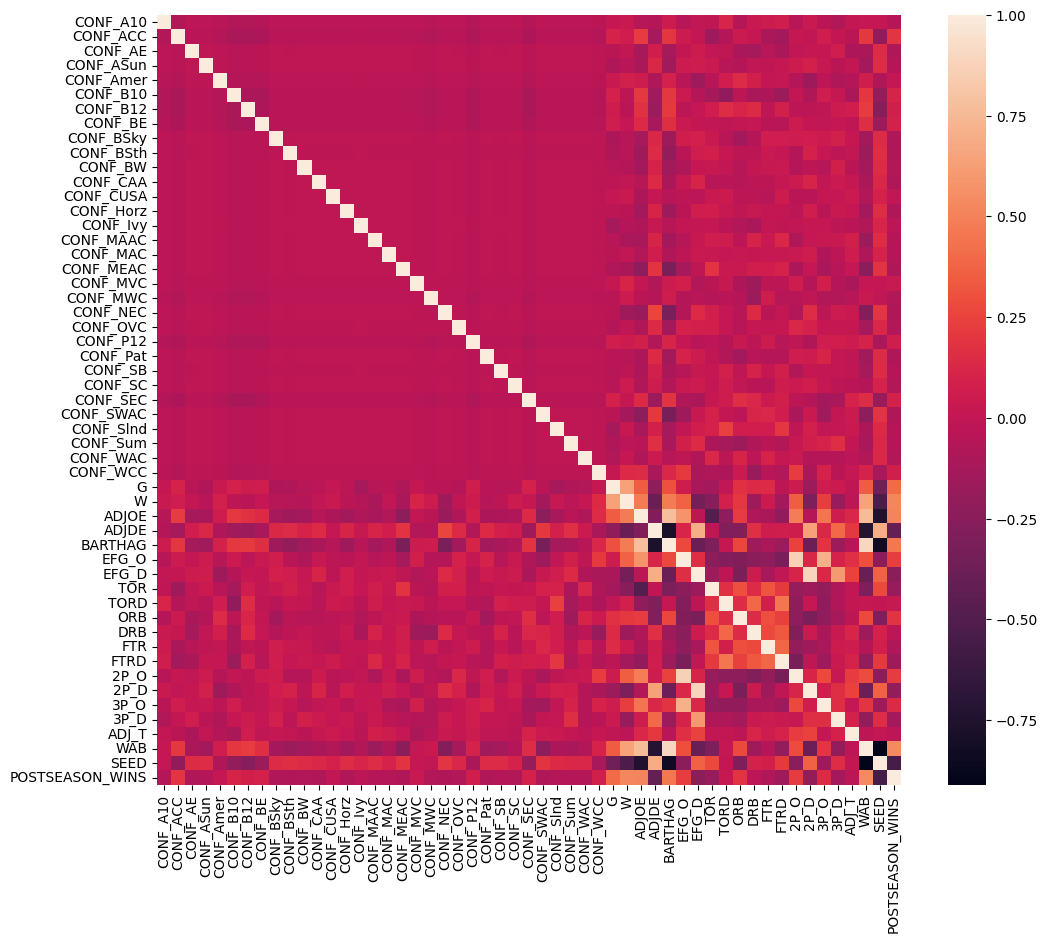

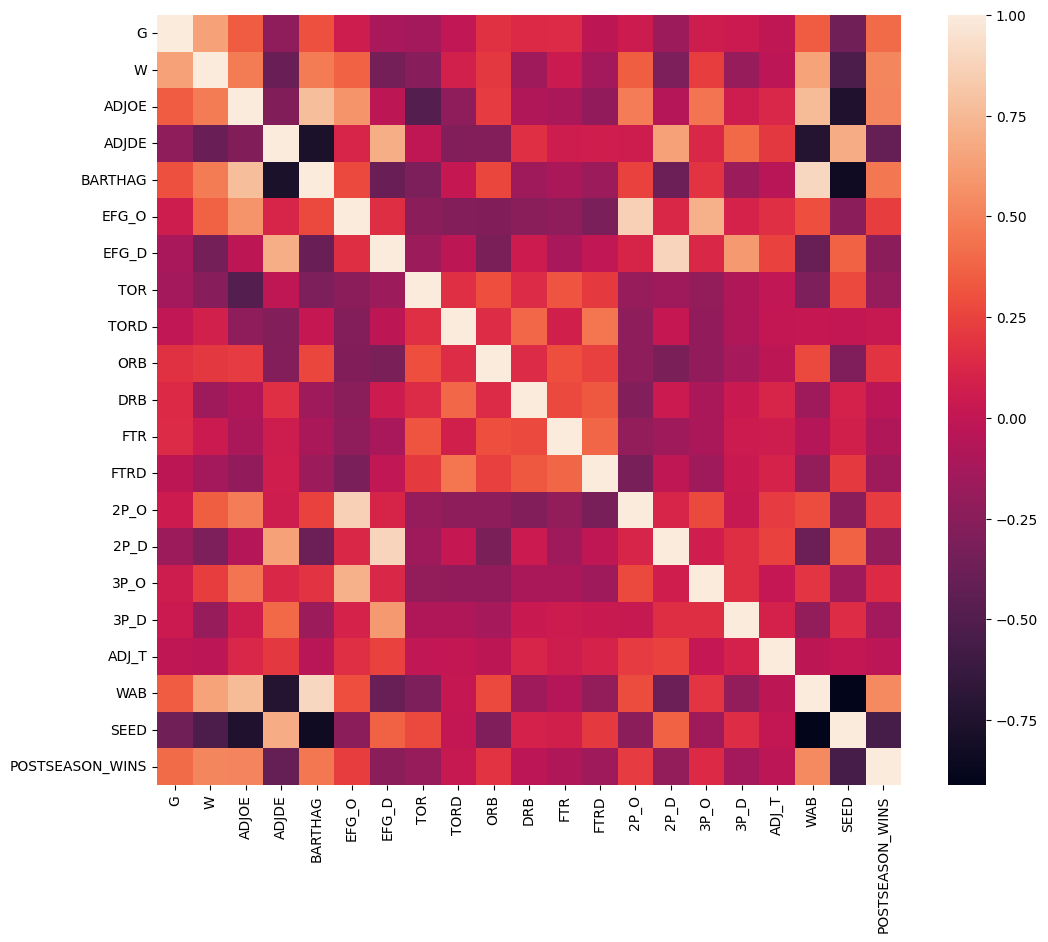

In [118]:
plot_corr_heatmap(df_corr_w_conf)
plot_corr_heatmap(df_corr_wo_conf)

In [128]:
## remove conferences, they don't seem to add anything and add a lot of complexity
df_prep = (df_prep.select(~cs.starts_with('CONF')))
df_prep.head(2)
df_prep.write_csv('../input_data/model_data.csv')